### Deep Learning Model for Asian Barrier Options

As shown in the previous notebook, there are a few problems to generate data on the fly 
   
    1. There is no model serialization so the trained model is not saved
    2. There is no validation dataset to check the training progress
    3. Most of the time is spent on Monte Carlo simulation hence the training is slow
    4. We use a few paths(1024) for each option parameter set which is noise and the model cannot converge to a low cost value.
The solution is to save the Monte Carlo simulation data on the disk. This allows us to

    1. Reuse the same dataset for different models and save the Monte Carlo simulation time
    2. Generate more accurate pricing data by increasing the number of paths
    
We will use CuPy to run the Monte Carlo simulation as it is the most efficient way. Taking the same OptionDataSet defined in the previous notebook:-

In [7]:
from cupy_dataset import OptionDataSet

Making the directories for the saved data files and the model check points:-

In [2]:
!mkdir -p datafiles
!mkdir -p check_points

Defining a function to generate the dataset file:- 

In [5]:
import torch

def gen_data(n_files = 630, options_per_file = 10000, seed=3):
    counter = 0
    ds = OptionDataSet(max_len=n_files * options_per_file, number_path=8192000, batch=1,
                   seed=seed)
    x = []
    y = []
    for i in ds:
        if counter!=0 and counter % options_per_file == 0:
            filename = 'datafiles/'+str(seed) + '_' + str(counter//options_per_file) + '.pth'
            state = (torch.cat(x, 0), torch.cat(y, 0))
            torch.save(state, filename)
            x = []
            y = []
        x.append(i[0].cpu())
        y.append(i[1].cpu())
        counter += 1
    return seed

It will generate files that contain `X` and `Y` matrix of size `option_per_file` and the filenames are in the format of `seed_group.pth`, we can test run with `n_files` = 5 and `options_per_file` = 16

In [8]:
gen_data(n_files=5, options_per_file = 16, seed=3)
X, Y = torch.load('datafiles/3_1.pth')
print(X)
print(Y)

tensor([[1.7910e+02, 6.8079e+01, 1.0688e+02, 2.5889e-01, 1.7393e-01, 1.4359e-01],
        [1.3597e+02, 5.8014e+01, 1.0772e+02, 1.1119e-01, 1.1278e-01, 3.3107e-03],
        [4.7951e+01, 3.6957e+01, 8.0480e+01, 2.6536e-01, 5.3653e-02, 7.2782e-02],
        [1.0026e+02, 8.1533e+00, 6.6216e+01, 3.8491e-02, 5.5396e-02, 1.4566e-01],
        [1.0416e+02, 7.9586e+01, 1.0620e+02, 1.2557e-01, 1.9639e-02, 3.0966e-02],
        [1.6851e+02, 9.7813e+01, 1.2468e+02, 1.1845e-01, 7.9473e-02, 1.0369e-01],
        [1.6673e+02, 7.4595e+01, 6.4872e+01, 3.8445e-01, 4.0116e-02, 1.5097e-01],
        [3.2400e+01, 1.4736e+01, 9.4934e+01, 2.5872e-01, 6.7174e-02, 1.0737e-01],
        [1.2953e+02, 8.5337e+01, 1.2570e+02, 1.6452e-01, 7.1083e-02, 1.9993e-01],
        [1.5920e+02, 1.3722e+02, 6.4502e+01, 3.5891e-01, 1.5036e-01, 1.8909e-01],
        [4.7439e+00, 6.8898e-01, 1.7892e+01, 1.6206e-02, 1.1772e-01, 1.1536e-01],
        [1.4590e+02, 5.5645e+00, 9.4114e+00, 9.8751e-02, 7.2455e-03, 1.2266e-01],
        [1.0537e

We will use DASK to generate dataset on multipe GPUs in this notebook

In [5]:
import dask
import dask_cudf
from dask.delayed import delayed
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:43453 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 540.94 GB


Following code is an example that generates `100x5x16` data points on 4 GPUs. For serious Deep Learning model training, we need millions of data points. You can try to change `n_files` and `options_per_file` to larger numbers

In [6]:
futures = []
for i in range(0, 100):
    future = client.submit(gen_data, 5, 16, i)
    futures.append(future)
results = client.gather(futures)
results

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

Once millions of data points are generated, we can combine the data points together and split them into training and validation datasets. 

In [7]:
import pathlib

files = list(pathlib.Path('datafiles/').glob('*.pth'))
trn_size = int(len(files)*0.7)
trn_files = files[:trn_size]
val_files = files[trn_size:]

trn_x = []
trn_y = []
count = 0

for i in trn_files:
    tensor = torch.load(i)
    if count % 10 == 0:
        print(count,'/',len(trn_files))
    trn_x.append(tensor[0])
    trn_y.append(tensor[1])
    count += 1

X = torch.cat(trn_x)
Y = torch.cat(trn_y)
torch.save((X,Y), 'trn.pth')

val_x = []
val_y = []
count = 0

for i in val_files:
    tensor = torch.load(i)
    if count % 10 == 0:
        print(count,'/',len(val_files))
    val_x.append(tensor[0])
    val_y.append(tensor[1])
    count += 1

X = torch.cat(val_x)
Y = torch.cat(val_y)
torch.save((X,Y), 'val.pth')

0 / 350
10 / 350
20 / 350
30 / 350
40 / 350
50 / 350
60 / 350
70 / 350
80 / 350
90 / 350
100 / 350
110 / 350
120 / 350
130 / 350
140 / 350
150 / 350
160 / 350
170 / 350
180 / 350
190 / 350
200 / 350
210 / 350
220 / 350
230 / 350
240 / 350
250 / 350
260 / 350
270 / 350
280 / 350
290 / 350
300 / 350
310 / 350
320 / 350
330 / 350
340 / 350
0 / 150
10 / 150
20 / 150
30 / 150
40 / 150
50 / 150
60 / 150
70 / 150
80 / 150
90 / 150
100 / 150
110 / 150
120 / 150
130 / 150
140 / 150


We created two data files `trn.pth` and `val.pth` for training and validation. We can define a new PyTorch Dataset to load data from file and write it to file. This dataset takes rank and world_size arguments for distributed training. It loads the whole dataset into the GPU memory and samples the data points according to the rank id so that dataset of different rank_id gives different data.

In [8]:
%%writefile filedataset.py
import torch


class OptionDataSet(torch.utils.data.Dataset):
    def __init__(self, filename, rank=0, world_size=5):
        tensor = torch.load(filename)
        self.tensor = (tensor[0].cuda(), tensor[1].cuda())
        self.length = len(self.tensor[0]) // world_size
        self.world_size = world_size
        self.rank = rank

    def __getitem__(self, index):
        index = index * self.world_size + self.rank
        return self.tensor[0][index], self.tensor[1][index]

    def __len__(self):
        return self.length

Writing filedataset.py


When training the deep learning models, one effective way to prevent over-fitting is to have separate validation dataset to monitor the out of sample performance. When the validation dataset  performance declines,  it means over-fitting is happening so we can  stop the training. We put everything together into one script that can train the model efficiently in multiple GPUs:

In [3]:
%%writefile distributed_training.py
import torch
from ignite.engine import Engine, Events
from torch.nn import MSELoss
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from apex import amp
import argparse
import os
from apex.parallel import DistributedDataParallel
import apex
from apex.optimizers import FusedLAMB
from model import Net
from filedataset import OptionDataSet
from ignite.metrics import MeanAbsoluteError
import ignite
import shutil
import torch.distributed as dist

parser = argparse.ArgumentParser()
parser.add_argument("--local_rank", default=0, type=int)
parser.add_argument("--path", default=None)
parser.add_argument("--mae_improv_tol", default=0.002, type=float)
args = parser.parse_args()

args.distributed = False
if 'WORLD_SIZE' in os.environ:
    args.distributed = int(os.environ['WORLD_SIZE']) > 1

if args.distributed:
    torch.cuda.set_device(args.local_rank)
    torch.distributed.init_process_group(backend='nccl',
                                         init_method='env://')

torch.backends.cudnn.benchmark = True

trn_dataset = OptionDataSet(filename='./trn.pth',
                            rank=dist.get_rank(),
                            world_size=int(os.environ['WORLD_SIZE']))
trn_dataset = torch.utils.data.DataLoader(trn_dataset,
                                          batch_size=1024,
                                          shuffle=True,
                                          num_workers=0)

val_dataset = OptionDataSet(filename='./val.pth',
                            rank=dist.get_rank(),
                            world_size=int(os.environ['WORLD_SIZE']))
val_dataset = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=1024,
                                          shuffle=False,
                                          num_workers=0)

model = Net().cuda()
optimizer = FusedLAMB(model.parameters(), lr=1e-3)
loss_fn = MSELoss()


model = apex.parallel.convert_syncbn_model(model, channel_last=True)
model, optimizer = amp.initialize(model, optimizer, opt_level='O1')


best_mae = 100000

if args.path is not None:
    def resume():
        global best_mae
        checkpoint = torch.load(args.path)
        best_mae = checkpoint['best_mae']
        model.load_state_dict(checkpoint['state_dict'])
        amp.load_state_dict(checkpoint['amp'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    resume()


if args.distributed:
    model = DistributedDataParallel(model)
    

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    loss = loss_fn(y, y_pred[:, 0])
    with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 500

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-5, 5e-6,
                                     len(trn_dataset),
                                     start_value_mult=0.999, end_value_mult=0.999,
                                     save_history=False
                                     )
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'check_points/model_best.pth.tar')


@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(trn_dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'iter', engine.state.iteration,
              'lr', scheduler.get_param())


metric = MeanAbsoluteError()
loss_m = ignite.metrics.Loss(loss_fn)

# run eval at one process only
def eval_update(engine, batch):
    model.eval()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    return y, y_pred[:, 0]
evaluator = Engine(eval_update)
metric.attach(evaluator, "MAE")
loss_m.attach(evaluator, "loss")
        
@trainer.on(Events.EPOCH_COMPLETED)
def log_evalnumber(engine):
    global best_mae
    mae_improv_tol = args.mae_improv_tol  # default 0.002 or 0.2% improvement
    evaluator.run(val_dataset, max_epochs=1)
    metrics = evaluator.state.metrics
    average_tensor = torch.tensor([metrics['MAE'], metrics['loss']]).cuda()
    torch.distributed.reduce(average_tensor, 0, op=torch.distributed.ReduceOp.SUM)
    torch.distributed.broadcast(average_tensor, 0)
    average_tensor = average_tensor/int(os.environ['WORLD_SIZE'])

    mae = average_tensor[0].item()
    is_best = False
    if (1 - mae / best_mae) >= mae_improv_tol or \
            (engine.state.epoch == engine.state.max_epochs and
             mae < best_mae):
        best_mae = mae
        is_best = True

    # print("RANK {}   Val Results - Epoch: {}  Avg MAE: {:.5f} loss: {:.5f} BEST MAE: {:.5f}"
    #      .format(dist.get_rank(), trainer.state.epoch, metrics['MAE'], metrics['loss'], best_mae))

    if dist.get_rank() == 0:
        print('Epoch {}/{}'.format(engine.state.epoch, engine.state.max_epochs))
        print('Best MAE Improvement Tolerance for checkpointing: {}%'.format(100 * mae_improv_tol))
        print("RANK {} AVG {} NGPUs, best-mae: {:.5f} mae: {:.5f} loss: {:.5f}".format(
            dist.get_rank(),
            int(os.environ['WORLD_SIZE']),
            best_mae,
            average_tensor[0].item(),
            average_tensor[1].item()))
        fname = 'check_points/current_pth.tar'
        if is_best:
            save_checkpoint({'epoch': trainer.state.epoch,
                             'state_dict': model.module.state_dict(),
                             'best_mae': best_mae,
                             'optimizer': optimizer.state_dict(),
                             'amp': amp.state_dict()
                             }, is_best,
                            filename=fname)
        inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05]]).cuda()
        res = model(inputs)
        print('test one example:', res.item())

trainer.run(trn_dataset, max_epochs=2000)

Overwriting distributed_training.py


Compared to the last notebook, it is a little complicated because 
* it handles the validation dataset evaluation
* it serializes the model into a file and keeps track of the best performed model based on the mean absolute error(MAE)
* it resumes the training from the file

We can launch the distributed training by the following command:-

In [ ]:
ngpus=!echo $(nvidia-smi -L | wc -l)
!python -m torch.distributed.launch --nproc_per_node={ngpus[0]} distributed_training.py

We need some patience to train the pricing model until it converges.

### Inference and Greeks
Once the training is converged, the best performed model is saved into `check_points/` directory. 

To get a good model, you need millions of data points to train the model until it converges. Usually it takes 10-20 hours in a single 8 GPUs DGX-1 machine. We trained the model with 10 million training data points and 5 million validation data points. We didn't explore what is the minimum number of training samples but simply use large number of data samples. You may get away by using less data points for training. 

To save your time, you can run the following commands to download the weights and use them for the inference

In [1]:
! ((test ! -f './check_points/model_best.pth.tar' ||  test ! -f './check_points/512/model_best.pth.tar') && \
  bash ./download_data.sh) || echo "Dataset is already present. No need to re-download it."

Dataset is already present. No need to re-download it.


We can load the model parameters and use it to do inference

In [2]:
from model import Net
import torch
checkpoint = torch.load('check_points/model_best.pth.tar')
model = Net().cuda()
model.load_state_dict(checkpoint['state_dict'])
inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05]]).cuda()
model(inputs)

tensor([[18.7140]], device='cuda:0', grad_fn=<AddmmBackward>)

One of the benefits of building a deep learning model is that the [Greeks](<https://en.wikipedia.org/wiki/Greeks_(finance)#First-order_Greeks>) can be easily computed. 
We just need to take advantage of the auto-grad feature in Pytorch. Following is an example to compute the first order differentiation for a multiple variable polynomial function. 

In [4]:
import torch
from torch.autograd import grad
'''
z = (xy)^2
x = 3, y =2

first order deriv [24 36]
'''
inputs = torch.tensor([3.0,2.0], requires_grad=True)
z = (inputs[0]*inputs[1])**2
first_order_grad = grad(z, inputs, create_graph=True)
print(first_order_grad)

(tensor([24., 36.], grad_fn=<AddBackward0>),)


We can use `grad` function to compute the first order differentiation for parameters 'K, B, S0, sigma, mu, r'

In [5]:
inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05]]).cuda()
inputs.requires_grad = True
x = model(inputs)
x.backward()
first_order_gradient = inputs.grad
first_order_gradient

tensor([[-6.7092e-01, -2.1257e-02,  7.8896e-01,  1.9219e+01,  4.8331e+01,
         -1.8419e+01]], device='cuda:0')

Here we are going to plot the Delta graph:-

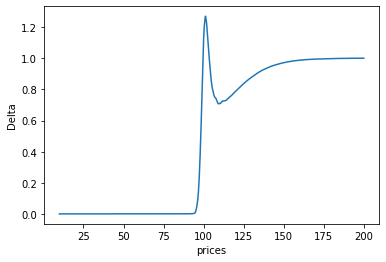

In [6]:
%matplotlib inline
import pylab
import numpy as np
def compute_delta(S):
    inputs = torch.tensor([[110.0, 100.0, S, 0.35, 0.1, 0.05]]).cuda()
    inputs.requires_grad = True
    x = model(inputs)
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]
prices = np.arange(10, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

Calculating the second order derivative is easy in PyTorch too. We just need to apply the `grad` function twice. Following is an example to calculate the second order derivative for the same polynomial function as above:

In [7]:
import torch
from torch.autograd import grad
'''
z = (xy)^2
x = 3, y =2

first order deriv [24 36]
d2z/dx2 = 8
d2z/dxdy = 24
d2z/dy2 = 18
'''

inputs = torch.tensor([3.0,2.0], requires_grad=True)
z = (inputs[0]*inputs[1])**2
first_order_grad = grad(z, inputs, create_graph=True)
second_order_grad_x, = grad(first_order_grad[0][0], inputs, retain_graph=True) #
second_order_grad_y, = grad(first_order_grad[0][1], inputs)
print(second_order_grad_x)
print(second_order_grad_y)

tensor([ 8., 24.])
tensor([24., 18.])


Use this mechanism, we can calculate the second order derivatives $\frac{\partial^2 P}{\partial K \partial S_0}$, $\frac{\partial^2 P}{\partial B \partial S_0}$, $\frac{\partial^2 P}{\partial S_0^2}$, $\frac{\partial^2 P}{\partial \sigma \partial S_0}$, $\frac{\partial^2 P}{\partial \mu \partial S_0}$, $\frac{\partial^2 P}{\partial r \partial S_0}$ in the following example.

In [9]:
import torch
from torch import Tensor
from torch.autograd import Variable
from torch.autograd import grad
from torch import nn

inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05]]).cuda()
inputs.requires_grad = True
x = model(inputs)

# instead of using loss.backward(), use torch.autograd.grad() to compute gradients
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
loss_grads = grad(x, inputs, create_graph=True)
drv = grad(loss_grads[0][0][2], inputs)
drv

(tensor([[-0.0143,  0.0039,  0.0098, -0.3183,  1.1455, -0.7876]],
        device='cuda:0'),)

Gamma is the second order differenation of `S`. We can plot the the Gamma curve as a function of the stock price

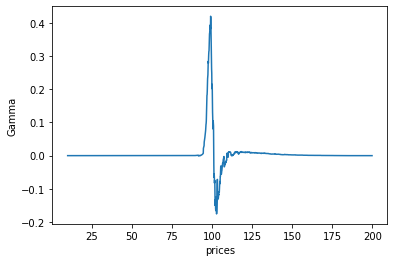

In [11]:
import pylab
import numpy as np
def compute_gamma(S):
    inputs = torch.tensor([[110.0, 100.0, S, 0.35, 0.1, 0.05]]).cuda()
    inputs.requires_grad = True
    x = model(inputs)
    loss_grads = grad(x, inputs, create_graph=True)
    drv = grad(loss_grads[0][0][2], inputs)
    return drv[0][0][2]

prices = np.arange(10, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_gamma(p).item())
fig2 = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Gamma')
fig2

[Implied volatility](https://en.wikipedia.org/wiki/Implied_volatility) is the forecasted volatility of the underlying asset based on the quoted prices of the option. It is the reverse mapping of price to the option parameter given the model which is hard to do with the Monte Carlo simulation approach. But if we have the deep learning pricing model, it is an easy task. We can first plot the relationship between volatility and the option price

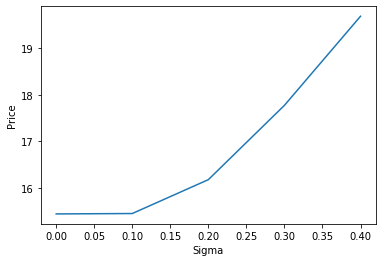

In [13]:
import pylab
import numpy as np
def compute_price(sigma):
    inputs = torch.tensor([[110.0, 100.0, 120.0, sigma, 0.1, 0.05]]).cuda()
    x = model(inputs)
    return x.item()
sigmas = np.arange(0, 0.5, 0.1)
prices = []
for s in sigmas:
    prices.append(compute_price(s))
fig3 = pylab.plot(sigmas, prices)
pylab.xlabel('Sigma')
pylab.ylabel('Price')
fig3

Given the prices `P`, the implied volatility is the root of the function `compute_price`. We can use bisection to find the root.

In [14]:
def bisection_root(small, large, fun, target, EPS=1e-6):
    if fun(large) - target < 0:
        print('upper bound is too small')
        return None
    if fun(small) - target > 0:
        print('lower bound is too large')
        return None
    while large - small > EPS:
        mid = (large + small) / 2.0
        if fun(mid) - target >= 0:
            large = mid
        else:
            small = mid
    mid = (large + small) / 2.0
    return mid, abs(fun(mid) - target)
quoted_price = 16.0
sigma, err = bisection_root(0, 0.5, compute_price, quoted_price)
print('implied volativity', sigma, 'error', err)     

implied volativity 0.18517351150512695 error 4.76837158203125e-06
